 LIBRARIES

In [814]:
import numpy as np
import cv2
from scipy.fftpack import dct,idct
from PIL import Image as im
from skimage.metrics import mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt , log10
import PIL

LOAD THE IMAGE

In [815]:
rgb_img = cv2.imread('kodim01.png')
input_img = rgb_img
num_pxls = 1   ## number of pixels you wants in the zigzag
block_size=8

# ENCODING PART

Converting to new dimensions such that row and column both divisible by 8

In [816]:
height, width, channels = rgb_img.shape
new_height = height
if (height % 8 !=0 ):
    new_height = height-height % 8 +8

# Create a new array of zeros with the new dimensions
new_img = np.zeros((new_height, width, channels), dtype=np.uint8)

# Copy the original image into the top portion of the new array
new_img[:height,:,:] = rgb_img[:,:,:]

new_width = width
if (width%8 !=0 ):
    new_width = width-width%8 +8

new_img = np.zeros((height, new_width, channels), dtype=np.uint8)

# Copy the original image into the left portion of the new array
new_img[:,:width,:] = rgb_img[:,:,:]
rgb_img = new_img

Convert the RGB image to YUV format

In [817]:
new_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2YUV)

# breaking the yuv image to different components (y,u,v)
y,u,v = cv2.split(new_img)
y_real=y
u_real=u
v_real=v

number of blocks in the images

In [818]:
# number of blocks in the images
num_x_blocks = new_img.shape[1]/8
num_y_blocks = new_img.shape[0]/8

# Create an empty list to store the blocks
y_blocks = []
u_blocks = []
v_blocks = []

 Loop through the image pixels and extract each 8x8 block

In [819]:
# for y
for Y in range(0, height, 8):
    for X in range(0, width, 8):
        block = y[Y:Y+8, X:X+8]
        if block.shape == (8, 8):
            y_blocks.append(block)

# for u
for Y in range(0, height, 8):
    for X in range(0, width, 8):
        block = u[Y:Y+8, X:X+8]
        if block.shape == (8, 8):
            u_blocks.append(block)

# for v
for Y in range(0, height, 8):
    for X in range(0, width, 8):
        block = v[Y:Y+8, X:X+8]
        if block.shape == (8, 8):
            v_blocks.append(block)


 Apply the DCT to each block of y , u  and  v

In [820]:
y_dct_blocks = [dct(dct(block.T, norm='ortho').T, norm='ortho') for block in y_blocks]
u_dct_blocks = [dct(dct(block.T, norm='ortho').T, norm='ortho') for block in u_blocks]
v_dct_blocks = [dct(dct(block.T, norm='ortho').T, norm='ortho') for block in v_blocks]

 Define the quantization matrixd

In [821]:
quantization_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                               [12, 12, 14, 19, 26, 58, 60, 55],
                               [14, 13, 16, 24, 40, 57, 69, 56],
                               [14, 17, 22, 29, 51, 87, 80, 62],
                               [18, 22, 37, 56, 68, 109, 103, 77],
                               [24, 35, 55, 64, 81, 104, 113, 92],
                               [49, 64, 78, 87, 103, 121, 120, 101],
                               [72, 92, 95, 98, 112, 100, 103, 99]])

 Apply Quantization matrix to all y,u and v

In [822]:
y_qm=[np.round(np.divide(matrix, quantization_matrix)) for matrix in y_dct_blocks]
u_qm=[np.round(np.divide(matrix, quantization_matrix)) for matrix in u_dct_blocks]
v_qm=[np.round(np.divide(matrix, quantization_matrix)) for matrix in v_dct_blocks]

  ZIG ZAG

In [823]:
def zigzag(matrix,num_pxls):
    rows, cols = matrix.shape
    output = []
    i, j, k = 0, 0, 0
    for _ in range(rows * cols):
        if(num_pxls>k):
            output.append(matrix[i][j])
            k+=1
        else :
            output.append(0)
        if (i + j) % 2 == 0:  # even diagonal
            if j == cols - 1:
                i += 1
            elif i == 0:
                j += 1
            else:
                i -= 1
                j += 1
        else:  # odd diagonal
            if i == rows - 1:
                j += 1
            elif j == 0:
                i += 1
            else:
                i += 1
                j -= 1
    return output

Opening file to write

In [824]:
file=open("jpegcode.txt",'w')
tempt = [new_height,new_width,block_size]
for j in tempt:
    file.write("%s "%j)
file.write("0\n")

# inserting zigzag matrix in lists 
y_zigzag = [zigzag(matrix,num_pxls) for matrix in y_qm]
y_zigzag=np.int8(y_zigzag)

u_zigzag = [zigzag(matrix,num_pxls) for matrix in u_qm]
u_zigzag=np.int8(u_zigzag)

v_zigzag = [zigzag(matrix,num_pxls) for matrix in v_qm]
v_zigzag=np.int8(v_zigzag)

WRITING TEXT IN THE JPEGTEXT FILE

In [825]:
count=0
print(len(y_zigzag))
for i in range(0,len(y_zigzag)):
    tempy=np.trim_zeros(y_zigzag[i],trim='b')
    tempu=np.trim_zeros(u_zigzag[i],trim='b')
    tempv=np.trim_zeros(v_zigzag[i],trim='b')
    count+=len(tempy)+len(tempu)+len(tempv) + 3
    for j in tempy:
        file.write("%s "%j)
    file.write("0\n")
    for j in tempu:
        file.write("%s "%j)

    file.write("0\n")
    for j in tempv:
        file.write("%s "%j)
    file.write("0\n")

6144


printing compression ratio

In [826]:
ratio_temp = input_img.shape[0]*input_img.shape[1]*24/(count*8)
print("COMPRESSION RATIO: ",input_img.shape[0]*input_img.shape[1]*24/(count*8))

COMPRESSION RATIO:  32.0


# DECODING PART

function ZigZag to Matrix

In [827]:
def zigzag_to_matrix(zigzag_list):
    n = int(len(zigzag_list)**0.5)
    matrix = [[0] * n for _ in range(n)]
    i, j = 0, 0
    for k, val in enumerate(zigzag_list):
        matrix[i][j] = val
        if (i + j) % 2 == 0:  # even diagonal
            if j == n - 1:
                i += 1
            elif i == 0:
                j += 1
            else:
                i -= 1
                j += 1
        else:  # odd diagonal
            if i == n - 1:
                j += 1
            elif j == 0:
                i += 1
            else:
                i += 1
                j -= 1
    return matrix

OPENING FILE AND READ

In [828]:
y_zigzag=[]
u_zigzag = []
v_zigzag = []

count  = 0
temp = -1
with open('jpegcode.txt', 'r') as f:
    # Initialize an empty list to hold the lists of integers
    
    # Loop over each line in the file
    for line in f:
        # Strip any whitespace from the line
        line = line.strip()
        
        # Split the line into individual integers
        integers = [float(x) for x in line.split()]
        
        # Append the list of integers to the list of lists
        if temp==-1:
            height = integers[0]
            width = integers[1]
            block_size = integers[2]
            temp =0

        elif temp == 0:
            y_zigzag.append(integers)
            temp =1
        elif temp == 1:
            u_zigzag.append(integers)
            temp =2
        else:
            v_zigzag.append(integers)
            temp =0
        count+=1

GETTING Q MATRIX FROM ZIGZAG

In [829]:
y_qm = []
u_qm = []
v_qm = []

# Loop through each matrix
for matrix in y_zigzag:
    # Calculate the number of zeroes to add
    num_zeroes = 64 - len(matrix)

    # Create a new array of the desired length, with zeros at the end
    new_array = np.concatenate([matrix, np.zeros(num_zeroes)], axis=0)

    # # Add the zeroes to the end of the list
    matrix += [0] * num_zeroes
    y_qm.append(zigzag_to_matrix(new_array))

for matrix in u_zigzag:
    num_zeroes = 64 - len(matrix)
    new_array = np.concatenate([matrix, np.zeros(num_zeroes)], axis=0)
    matrix += [0] * num_zeroes
    u_qm.append(zigzag_to_matrix(new_array))

for matrix in v_zigzag:
    num_zeroes = 64 - len(matrix)
    new_array = np.concatenate([matrix, np.zeros(num_zeroes)], axis=0)
    matrix += [0] * num_zeroes
    v_qm.append(zigzag_to_matrix(new_array))

Apply Inverse Quantization matrix to all y,u and v

In [830]:
y_dct_blocks=[np.round(np.multiply(matrix, quantization_matrix)) for matrix in y_qm]
u_dct_blocks=[np.round(np.multiply(matrix, quantization_matrix)) for matrix in u_qm]
v_dct_blocks=[np.round(np.multiply(matrix, quantization_matrix)) for matrix in v_qm]

Applying Inverse DCT to all y,u and v

In [831]:
y_idct_blocks = [idct(idct(block.T, norm='ortho').T, norm='ortho') for block in y_dct_blocks]
u_idct_blocks = [idct(idct(block.T, norm='ortho').T, norm='ortho') for block in u_dct_blocks]
v_idct_blocks = [idct(idct(block.T, norm='ortho').T, norm='ortho') for block in v_dct_blocks]

#  to y,u and v 
height = new_height
width = new_width
num_blocks = len(y_idct_blocks)

Create an empty matrix with the calculated dimensions

In [832]:
y = np.zeros((height, width))
u = np.zeros((height, width))
v = np.zeros((height, width))

Extracting  y , u and v

In [833]:
height = new_height
width = new_width

for Y in range(0, height, 8):
    for X in range(0, width, 8):
        X_out = abs(y_idct_blocks[Y//8*width//8 + X//8])
        y = np.uint8(y)
        y[Y:Y+8, X:X+8] = np.asarray(X_out, dtype = np.uint8)

# Extract u
for Y in range(0, height, 8):
    for X in range(0, width, 8):
        X_out = abs(u_idct_blocks[Y//8*width//8 + X//8])
        u = np.uint8(u)
        u[Y:Y+8, X:X+8] = np.asarray(X_out, dtype = np.uint8)

# Extract v
for Y in range(0, height, 8):
    for X in range(0, width, 8):
        X_out = abs(v_idct_blocks[Y//8*width//8 + X//8])
        v = np.uint8(v)
        v[Y:Y+8, X:X+8] = np.asarray(X_out, dtype = np.uint8)
        


Merge YUV and form RGB image

In [834]:

merged_yuv_image = cv2.merge((y,u,v))
out_rgb_img = cv2.cvtColor(merged_yuv_image, cv2.COLOR_YUV2BGR)
import matplotlib.image

# out_rgb_img.save("jpeg1.jpeg")
np.savetxt('out2.txt', y, fmt='%d')

Showing image

Text(0.5, 1.0, 'Compressed Image')

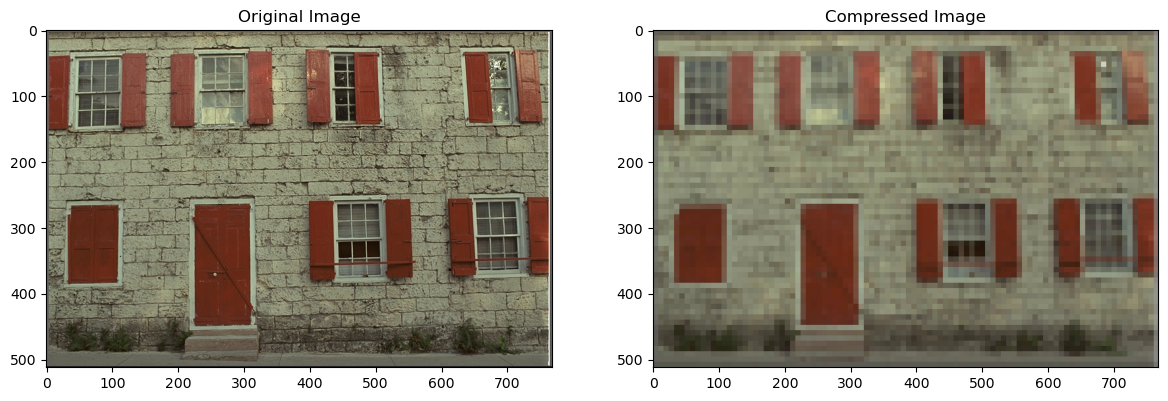

In [835]:
plt.figure(figsize=[30,10])
plt.subplot(141);plt.imshow(cv2.cvtColor(input_img,cv2.COLOR_BGR2RGB));plt.title("Original Image")
plt.subplot(142);plt.imshow(cv2.cvtColor(out_rgb_img,cv2.COLOR_BGR2RGB));plt.title("Compressed Image")

 Calculating RMSE and printing it

In [836]:
# Calculate the mean squared error in y
mse_y = mean_squared_error(y, y_real)

# Calculate the mean squared error in u
mse_u = mean_squared_error(u, u_real)

# Calculate the mean squared error in v
mse_v = mean_squared_error(v, v_real)

# Calculate the mean squared error rgbs
mse = mean_squared_error(out_rgb_img, rgb_img)

# Calculate the RMSE
rmse_y = np.sqrt(mse_y)
rmse_u = np.sqrt(mse_u)
rmse_v = np.sqrt(mse_v)
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 24.87111500146881


PSNR

In [837]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):                    
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

print("PSNR:",PSNR(rgb_img, out_rgb_img))
print("COMPRESSION RATIO:",ratio_temp)
print("RMSE:",rmse)

PSNR: 29.207134411753074
COMPRESSION RATIO: 32.0
RMSE: 24.87111500146881


In [838]:
1

3